<a href="https://colab.research.google.com/github/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT/blob/main/Covid_19_Vaccine_Tweet_Annotation_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook Initiatlization and Data Preparation

## **Author: Derek Carey**

Corpus data as well as the code used for analysis is provided in a repository at https://github.com/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT
. Inquiries should be directed to: derek.carey@outlook.com.[link text](https://)

## **About:**

The Covid-19_Vaccine_Tweet_Annotation_BERT notebook trains on a corpus of COVID-19 vaccine tweets to learn to perform several classification tasks associated with vaccination sentiment. Three models were downloaded from Tensorflow Hub, fined-tuned, and evaluated:

1. bert_en_cased_L-12_H-768_A-12/3
2. electra_base/2
3. bert_en_uncased_L-12_H-768_A-12/3


Always run the following Colab notebook section prior to executing code for any of the three 'Model Evaluation' sections. Due to memory constraints it is recommend to run each model segment as a seperate runtime. 


Install necessary Python libraries using pip. Future package changes require adjustments to code. 

In [1]:
!pip install tensorflow==2.4.1
!pip install  tensorflow-text==2.4.1   
!pip install tf-models-official==2.4
!pip install emoji

Import model packages. Set a random seed for Tensorflow to ensure results are repeatable

In [2]:
import pandas as pd
import os
import nltk
import re
import string
import shutil
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
from official.nlp import optimization  # to create AdamW optmizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import emoji
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from google.colab import files
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

# Set random seed for tensorflow for model consistency
tf.random.set_seed(3)

Check to make sure GPU is in use

In [3]:
# Check to make sure GPU is in use

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


Create a list to store model results. This will be appended once models are evaluated and eventually saved to a file. 

In [4]:
model_final_test_results = list()

The following function removes emojis from corpus text.

In [5]:
# Function: Takes in a text sequence as input and returns a sequence with emojis removed

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

Check to see if the corpus file is already on Github. If not, then download it from the Github repo.

In [6]:
import urllib.request

#set working Directory to where class corpus is saved.
os.chdir('/content')

# Check to see if the corpus file is already on Github. If not, then download it from the Github repo
if not os.path.exists("Covid_Vaccine_Tweet_Corpus.xlsx"):
  url = 'https://github.com/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT/blob/main/Covid_Vaccine_Tweet_Corpus.xlsx?raw=true'
  print("download start!")
  filename, headers = urllib.request.urlretrieve(url, filename="Covid_Vaccine_Tweet_Corpus.xlsx")
  print("download complete!")
  print("download file location: ", filename)
  print("download headers: ", headers)


Set the Google colab directory to /content. Then use the Covid_Vaccine_Tweet_Corpus file to create a dataframe for processing. 

In [7]:
#set working Directory to where class corpus is saved.
os.chdir('/content')

#read in class corpus csv into python
data=pd.read_excel('Covid_Vaccine_Tweet_Corpus.xlsx','Corpus')


The corpus data file should only contain tweets related to vaccines. However, the dataframe is filtered to ensure only related tweets are included.

In [8]:
data = data[data['Vaccine Related']=='Yes']

Several additional fields are added to the corpus dataframe to convert text categories to a binary or categorical number. This step is required for processing labels. 

In [9]:

data['vaccination_label'] = data['Taken a Vaccine?'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
data['sentiment_label'] = data['Sentiment'].apply(lambda x: 0 if x == 'Positive' else 1 if x == 'Negative' else 2 if x == 'Neutral' else 2)
data['side_effect_label'] = data['Side Effects Referenced'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
data['negative_sentiment_reason_label'] = data['Negative Sentiment Reason'].apply(lambda x: 0 if x == 'Safety' else 1 if x == 'Efficacy'
                                                                         else 2 if x == 'Availability' else 3 if x == 'Other' else 4 if x == 'Not Negative' else 4)

Example of a record text with data (Negative sentiment rason is availability)

In [10]:
data.text[data['negative_sentiment_reason_label']==2].iloc[5]

'I’m an #essentialworker, #veterinarian, live in #YorkRegion(but not a hotspot area code)work in #Halton(but not hotspot area code)Too young for AZ,can’t work from home,can’t get #vaccinated I’m vaccine adjacent,not #vaccineeligible,terrified I’ll get #Covid and so 😡😩#onpoli'

Convert Emoji's in tweets to text so that they can be interpreted by BERT models

In [11]:
# Convert Emoji's in tweets to text so that they can be interpreted by BERT models
data['text'] = data['text'].apply(lambda x: emoji.demojize(x, delimiters=(" ", " "))) # 'game is on fire fire'

In [12]:
# Create a mapping of tfhub models for easy reference in later model construction

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


The build_classifier_model_binary function is used to generate binary models for vaccine determination and side-effect classification tasks. 

In [13]:
def build_classifier_model_binary():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [14]:
def build_classifier_model_softmax_3_class():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [15]:
def build_classifier_model_softmax_5_class():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [16]:

def create_checkpoint_callback(checkpoint_filepath):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='binary_accuracy',
        mode='max',
        save_best_only=True)
    return checkpoint_callback


    
def create_checkpoint_callback_categorical(checkpoint_filepath):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='categorical_accuracy',
        mode='max',
        save_best_only=True)
    return checkpoint_callback

In [17]:
# Functions for calculating recall, precission, and f1 scores for models. 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Sizing of train, validation, and test datasets is determined by a percentage of the overall corpus size. For the corpus, dataset sizes are set and printed.

In [18]:

train_size = int(0.7 * len(data))
val_size = int(0.10 * len(data))
test_size = int(0.20 * len(data))

print('Train Size: ', train_size)
print('Validation Size: ', val_size)
print('Test Size: ', test_size)

Train Size:  1400
Validation Size:  200
Test Size:  400


In [19]:
from sklearn.utils import shuffle

shuffled_data = shuffle(data, random_state=65)

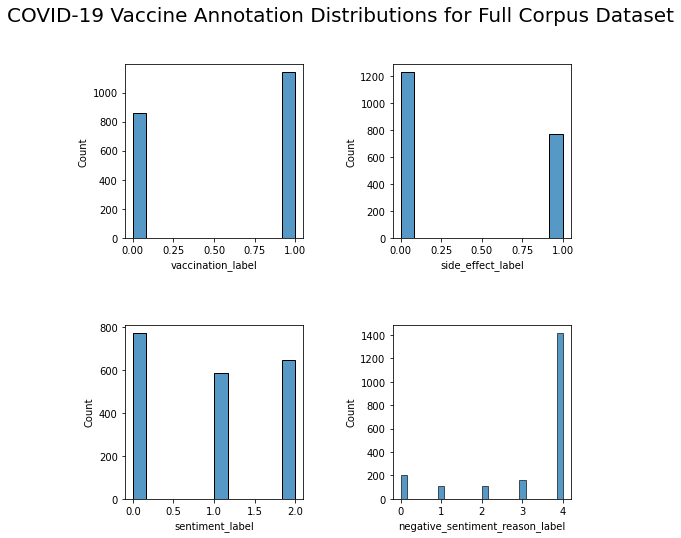

In [20]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(shuffled_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(shuffled_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = shuffled_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=shuffled_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Full Corpus Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [21]:
train_data = shuffled_data[:train_size]

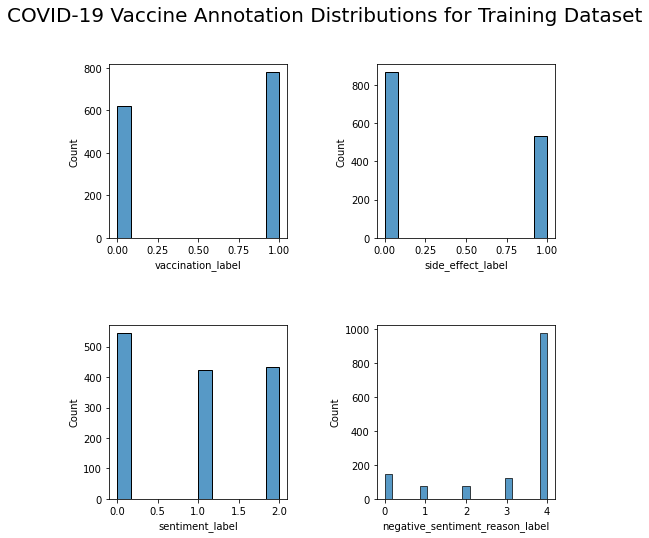

In [22]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(train_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(train_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = train_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=train_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Training Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [23]:
test_data = shuffled_data[train_size:(train_size + test_size)]

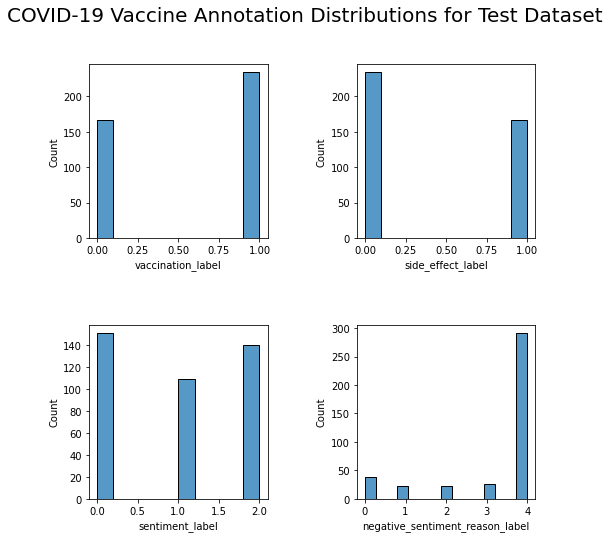

In [24]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(test_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(test_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = test_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=test_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Test Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [25]:
val_data = shuffled_data[(train_size + test_size):]

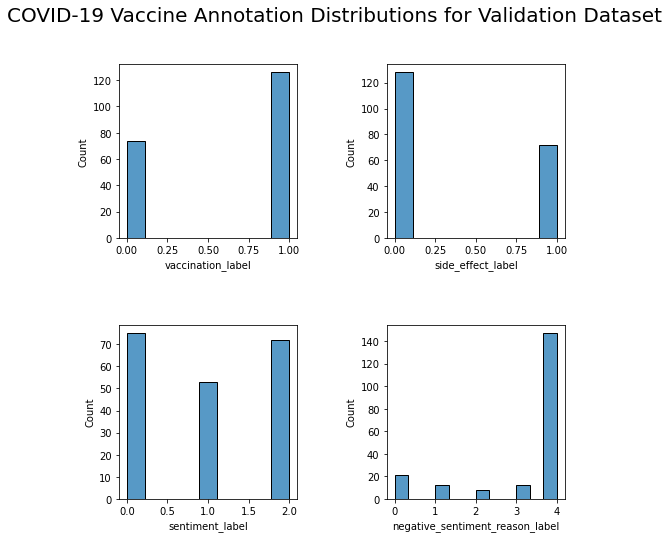

In [26]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(val_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(val_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = val_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=val_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Validation Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [27]:
m1_train_target = train_data.pop('vaccination_label')
m1_val_target = val_data.pop('vaccination_label')
m1_test_target = test_data.pop('vaccination_label')

m2_train_target = train_data.pop('side_effect_label')
m2_val_target = val_data.pop('side_effect_label')
m2_test_target = test_data.pop('side_effect_label')

m3_train_target = train_data.pop('sentiment_label')
m3_val_target = val_data.pop('sentiment_label')
m3_test_target = test_data.pop('sentiment_label')

m4_train_target = train_data.pop('negative_sentiment_reason_label')
m4_val_target = val_data.pop('negative_sentiment_reason_label')
m4_test_target = test_data.pop('negative_sentiment_reason_label')

In [28]:
m1_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, m1_train_target.values)).batch(16)
m1_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, m1_val_target.values)).batch(16)
m1_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, m1_test_target.values)).batch(16)

m2_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, m2_train_target.values)).batch(16)
m2_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, m2_val_target.values)).batch(16)
m2_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, m2_test_target.values)).batch(16)

m3_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, to_categorical(m3_train_target))).batch(16)
m3_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, to_categorical(m3_val_target))).batch(16)
m3_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, to_categorical(m3_test_target))).batch(16)

m4_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, to_categorical(m4_train_target))).batch(16)
m4_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, to_categorical(m4_val_target))).batch(16)
m4_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, to_categorical(m4_test_target))).batch(16)

In [29]:

# target = data.pop('vaccination_label')

# m0_dataset = tf.data.Dataset.from_tensor_slices((data['id'].values, target.values)).batch(16)
# m1_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, target.values)).batch(16)

# target = data.pop('side_effect_label')

# m2_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, target.values)).batch(16)

# target = data.pop('sentiment_label')
# m3_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, to_categorical(target))).batch(16)


# target = data.pop('negative_sentiment_reason_label')
# m4_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, to_categorical(target))).batch(16)

# BERT EN CASED Model Evaluation

## BERT EN CASED Classifer - Vaccine Determination

In [30]:

# train_size = int(0.7 * len(m1_dataset))
# val_size = int(0.10 * len(m1_dataset))
# test_size = int(0.20 * len(m1_dataset))


# full_dataset = m1_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# remaining = full_dataset.skip(train_size)
# val_dataset = remaining.take(val_size)
# test_dataset = remaining.skip(val_size)

In [31]:

# train_size = int(0.7 * len(m0_dataset))
# val_size = int(0.10 * len(m0_dataset))
# test_size = int(0.20 * len(m0_dataset))


# full_dataset = m0_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# remaining = full_dataset.skip(train_size)
# val_dataset = remaining.take(val_size)
# test_dataset = remaining.skip(val_size)

In [32]:
# # Generate Cofnusion Matrix from test_dataset - binary classification


# text_list = list()
# dataset_list = list()


# for batch in list(train_dataset.as_numpy_iterator()):

#   for item in batch[0]:

#     text_list.append(item)
#     dataset_list.append('train')
#     #y_pred.append(pred)

# for batch in list(val_dataset.as_numpy_iterator()):

#   for item in batch[0]:

#     text_list.append(item)
#     dataset_list.append('val')
#     #y_pred.append(pred)

# for batch in list(test_dataset.as_numpy_iterator()):

#   for item in batch[0]:

#     text_list.append(item)
#     dataset_list.append('test')




In [33]:
# print(len(text_list))

In [34]:
# pd.DataFrame(text_list, dataset_list).to_csv('testing_id4.csv')

In [35]:
# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))

In [36]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

#,tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

In [37]:
epochs = 10

checkpoint_filepath = './m1_bert_cased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [38]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [39]:
bert_model_name = 'bert_en_cased_L-12_H-768_A-12' 


tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3


In [40]:
bert_cased_m1 = build_classifier_model_binary()

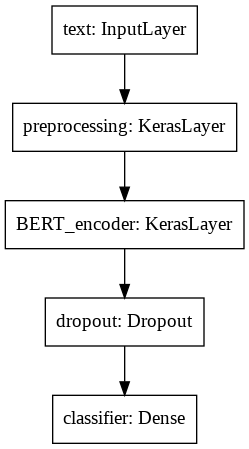

In [41]:
tf.keras.utils.plot_model(bert_cased_m1)

In [42]:


bert_cased_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [43]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs,callbacks = [model_checkpoint_callback]) #callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 35s 189ms/step - loss: 0.6586 - binary_accuracy: 0.6080 - f1_m: 0.6483 - precision_m: 0.6528 - recall_m: 0.7148 - val_loss: 0.3427 - val_binary_accuracy: 0.8750 - val_f1_m: 0.8985 - val_precision_m: 0.9203 - val_recall_m: 0.8908
Epoch 2/10
88/88 [==============================] - 16s 177ms/step - loss: 0.2835 - binary_accuracy: 0.9057 - f1_m: 0.9095 - precision_m: 0.9375 - recall_m: 0.8954 - val_loss: 0.3794 - val_binary_accuracy: 0.8950 - val_f1_m: 0.9183 - val_precision_m: 0.9106 - val_recall_m: 0.9358
Epoch 3/10
88/88 [==============================] - 16s 178ms/step - loss: 0.1742 - binary_accuracy: 0.9527 - f1_m: 0.9545 - precision_m: 0.9700 - recall_m: 0.9440 - val_loss: 0.4105 - val_binary_accuracy: 0.9000 - val_f1_m: 0.9220 - val_precision_m: 0.9223 - val_recall_m: 0.9294
Epoch 4/10
88/88 [==============================] - 16s 178ms/step - loss: 0

In [44]:
bert_cased_m1.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


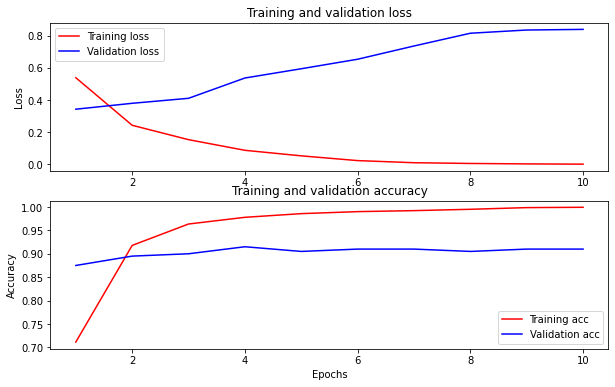

In [45]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [46]:
loss, accuracy, f1, precision, recall = bert_cased_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 91.750002
Test Loss:  0.4861723780632019
Test Precision:  0.9410812854766846
Test Recall:  0.9194439649581909
Test f1_score:  0.9262953400611877


In [47]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_cased_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [48]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]



# Commented out code can be used to print text with predicted/actual labels. This is helpful for troubleshooting
# count = 0 

# while count < len(text_list):
#   print(text_list[count], predicted_categories[count], true_label_list[count])
#   count += 1


In [49]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)

Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Taken Vaccine?')

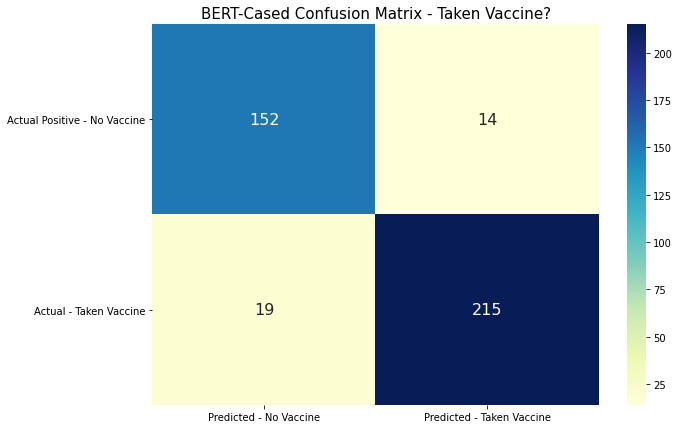

In [50]:


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [51]:


# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)




# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.9175
Recall Score:  0.9175
f1 Score:  0.9175
Accuracy Score 0.9175
Macro Precision Score:  0.9138767588549248
Macro Recall Score:  0.9172330347029142
Macro f1 Score:  0.915401426639578
Accuracy Score 0.9175


## BERT EN CASED Classifier - Side-Effect Determintation

In [52]:
# train_size = int(0.7 * len(m2_dataset))
# val_size = int(0.10 * len(m2_dataset))
# test_size = int(0.20 * len(m2_dataset))


# full_dataset = m2_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [53]:
epochs = 10

checkpoint_filepath = './m2_bert_cased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [54]:
bert_cased_m2 = build_classifier_model_binary()


In [55]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [56]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [57]:
bert_cased_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [58]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks = [model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 33s 187ms/step - loss: 0.6598 - binary_accuracy: 0.6373 - f1_m: 0.0500 - precision_m: 0.0891 - recall_m: 0.0405 - val_loss: 0.2862 - val_binary_accuracy: 0.8850 - val_f1_m: 0.8008 - val_precision_m: 0.9121 - val_recall_m: 0.7474
Epoch 2/10
88/88 [==============================] - 16s 178ms/step - loss: 0.3727 - binary_accuracy: 0.8555 - f1_m: 0.7463 - precision_m: 0.8739 - recall_m: 0.6854 - val_loss: 0.2237 - val_binary_accuracy: 0.9200 - val_f1_m: 0.8757 - val_precision_m: 0.9038 - val_recall_m: 0.8595
Epoch 3/10
88/88 [==============================] - 16s 178ms/step - loss: 0.1975 - binary_accuracy: 0.9353 - f1_m: 0.9060 - precision_m: 0.9642 - recall_m: 0.8671 - val_loss: 0.3388 - val_binary_accuracy: 0.9150 - val_f1_m: 0.8581 - val_precision_m: 0.9102 - val_recall_m: 0.8275
Epoch 4/10
88/88 [==============================] - 16s 178ms/step - loss: 0

In [59]:
bert_cased_m2.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


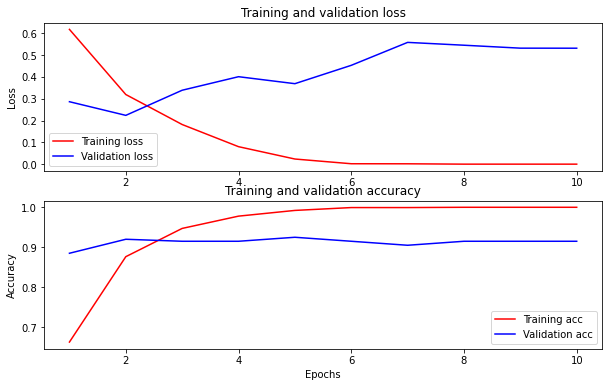

In [60]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [61]:
loss, accuracy, f1, precision, recall = bert_cased_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 86.000001
Test Loss:  1.0021181106567383
Test Precision:  0.8197734355926514
Test Recall:  0.8364257216453552
Test f1_score:  0.8073137402534485


In [62]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_cased_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


Convert probability vector into binary value of 0 (has not recieved vaccine) or 1 (has received a vaccine or has one scheduled)


In [63]:
# Convert probability vector to discrete 0 or 1 value (0 - no side effects, 1 - side effects)
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

In [64]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)

Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Side Effect Reference')

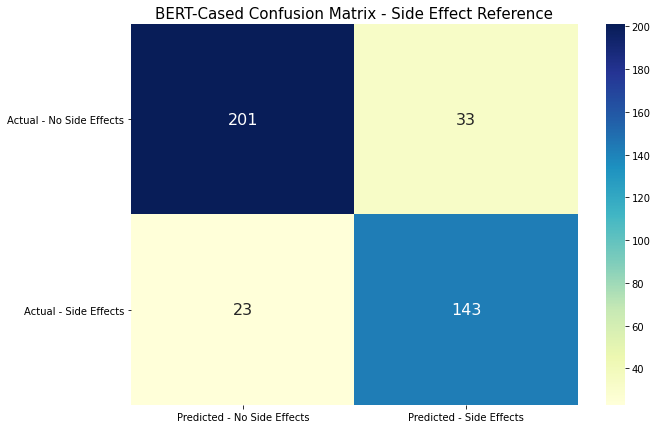

In [65]:

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Side Effect Reference',fontsize = 15)

In [66]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.86
Recall Score:  0.86
f1 Score:  0.8599999999999999
Accuracy Score 0.86
Macro Precision Score:  0.8549107142857143
Macro Recall Score:  0.8602100710534446
Macro f1 Score:  0.856993283791721


## BERT EN CASED Classifier - Sentiment Analysis

In [67]:
# train_size = int(0.7 * len(m3_dataset))
# val_size = int(0.10 * len(m3_dataset))
# test_size = int(0.20 * len(m3_dataset))


# full_dataset = m3_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [68]:
epochs = 10

checkpoint_filepath = './m3_bert_cased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [69]:
bert_cased_m3 = build_classifier_model_softmax_3_class()


In [70]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [71]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [72]:


bert_cased_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [73]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 33s 188ms/step - loss: 1.2621 - categorical_accuracy: 0.3771 - f1_m: 0.2780 - precision_m: 0.4089 - recall_m: 0.2209 - val_loss: 0.6942 - val_categorical_accuracy: 0.7200 - val_f1_m: 0.6832 - val_precision_m: 0.7303 - val_recall_m: 0.6442
Epoch 2/10
88/88 [==============================] - 16s 178ms/step - loss: 0.7729 - categorical_accuracy: 0.6756 - f1_m: 0.6626 - precision_m: 0.7105 - recall_m: 0.6239 - val_loss: 0.5544 - val_categorical_accuracy: 0.7800 - val_f1_m: 0.7859 - val_precision_m: 0.7990 - val_recall_m: 0.7740
Epoch 3/10
88/88 [==============================] - 16s 178ms/step - loss: 0.4394 - categorical_accuracy: 0.8327 - f1_m: 0.8297 - precision_m: 0.8496 - recall_m: 0.8128 - val_loss: 0.6762 - val_categorical_accuracy: 0.8100 - val_f1_m: 0.8018 - val_precision_m: 0.8160 - val_recall_m: 0.7885
Epoch 4/10
88/88 [============================

In [74]:
bert_cased_m3.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


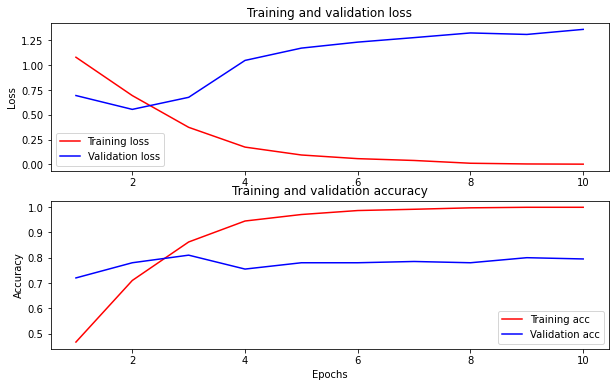

In [75]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [76]:
loss, accuracy, f1, precision, recall = bert_cased_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 76.999998
Test Loss:  1.4511425495147705
Test Precision:  0.7714999914169312
Test Recall:  0.7699999809265137
Test f1_score:  0.7707257866859436


In [77]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.argmax(bert_cased_m3.predict(tf.constant([item])),1))
    y_pred = tf.argmax(bert_cased_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype

Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine Sentiment')

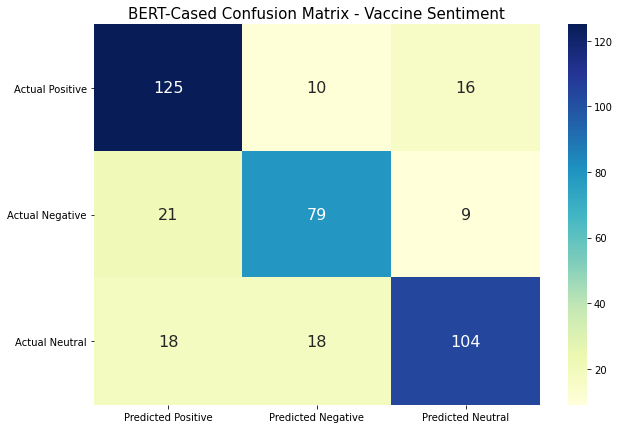

In [78]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [79]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.77
Recall Score:  0.77
f1 Score:  0.7699999999999999
Accuracy Score 0.77
Macro Precision Score:  0.7689048097827208
Macro Recall Score:  0.7651474515318005
Macro f1 Score:  0.7661221586252566



 ## BERT EN CASED Classifier - Negative Sentiment Reason


In [80]:
# train_size = int(0.7 * len(m4_dataset))
# val_size = int(0.10 * len(m4_dataset))
# test_size = int(0.20 * len(m4_dataset))


# full_dataset = m4_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [81]:
epochs = 10

checkpoint_filepath = './m4_bert_cased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [82]:
bert_cased_m4 = build_classifier_model_softmax_5_class()

In [83]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [84]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [85]:
bert_cased_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [86]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 33s 189ms/step - loss: 1.1732 - categorical_accuracy: 0.6136 - f1_m: 0.4584 - precision_m: 0.6822 - recall_m: 0.3919 - val_loss: 0.7212 - val_categorical_accuracy: 0.7400 - val_f1_m: 0.7585 - val_precision_m: 0.8681 - val_recall_m: 0.6827
Epoch 2/10
88/88 [==============================] - 16s 178ms/step - loss: 0.8185 - categorical_accuracy: 0.6935 - f1_m: 0.7003 - precision_m: 0.8540 - recall_m: 0.6030 - val_loss: 0.5760 - val_categorical_accuracy: 0.7850 - val_f1_m: 0.7811 - val_precision_m: 0.8908 - val_recall_m: 0.7067
Epoch 3/10
88/88 [==============================] - 16s 178ms/step - loss: 0.4761 - categorical_accuracy: 0.8456 - f1_m: 0.8196 - precision_m: 0.9057 - recall_m: 0.7545 - val_loss: 0.5799 - val_categorical_accuracy: 0.8100 - val_f1_m: 0.8097 - val_precision_m: 0.8399 - val_recall_m: 0.7837
Epoch 4/10
88/88 [============================

In [87]:
bert_cased_m4.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


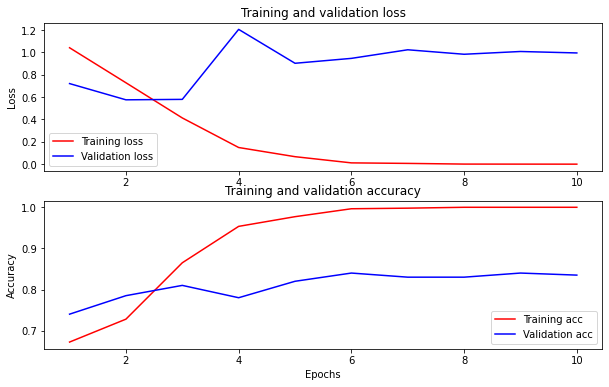

In [88]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [89]:
loss, accuracy, f1, precision, recall = bert_cased_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 82.749999
Test Loss:  1.069320797920227
Test Precision:  0.8321666717529297
Test Recall:  0.8274999856948853
Test f1_score:  0.8297579884529114


In [90]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:
    #print(tf.argmax(classifier_model_sentiment.predict(tf.constant([item])),1))
    y_pred = tf.argmax(bert_cased_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason')

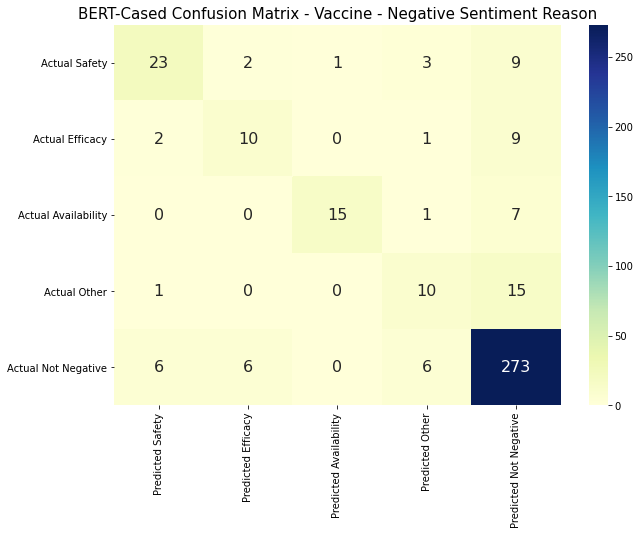

In [91]:
cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [92]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8275
Recall Score:  0.8275
f1 Score:  0.8275
Accuracy Score 0.8275
Macro Precision Score:  0.7120401009178965
Macro Recall Score:  0.6069484479991922
Macro f1 Score:  0.6511758102402035


Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason')

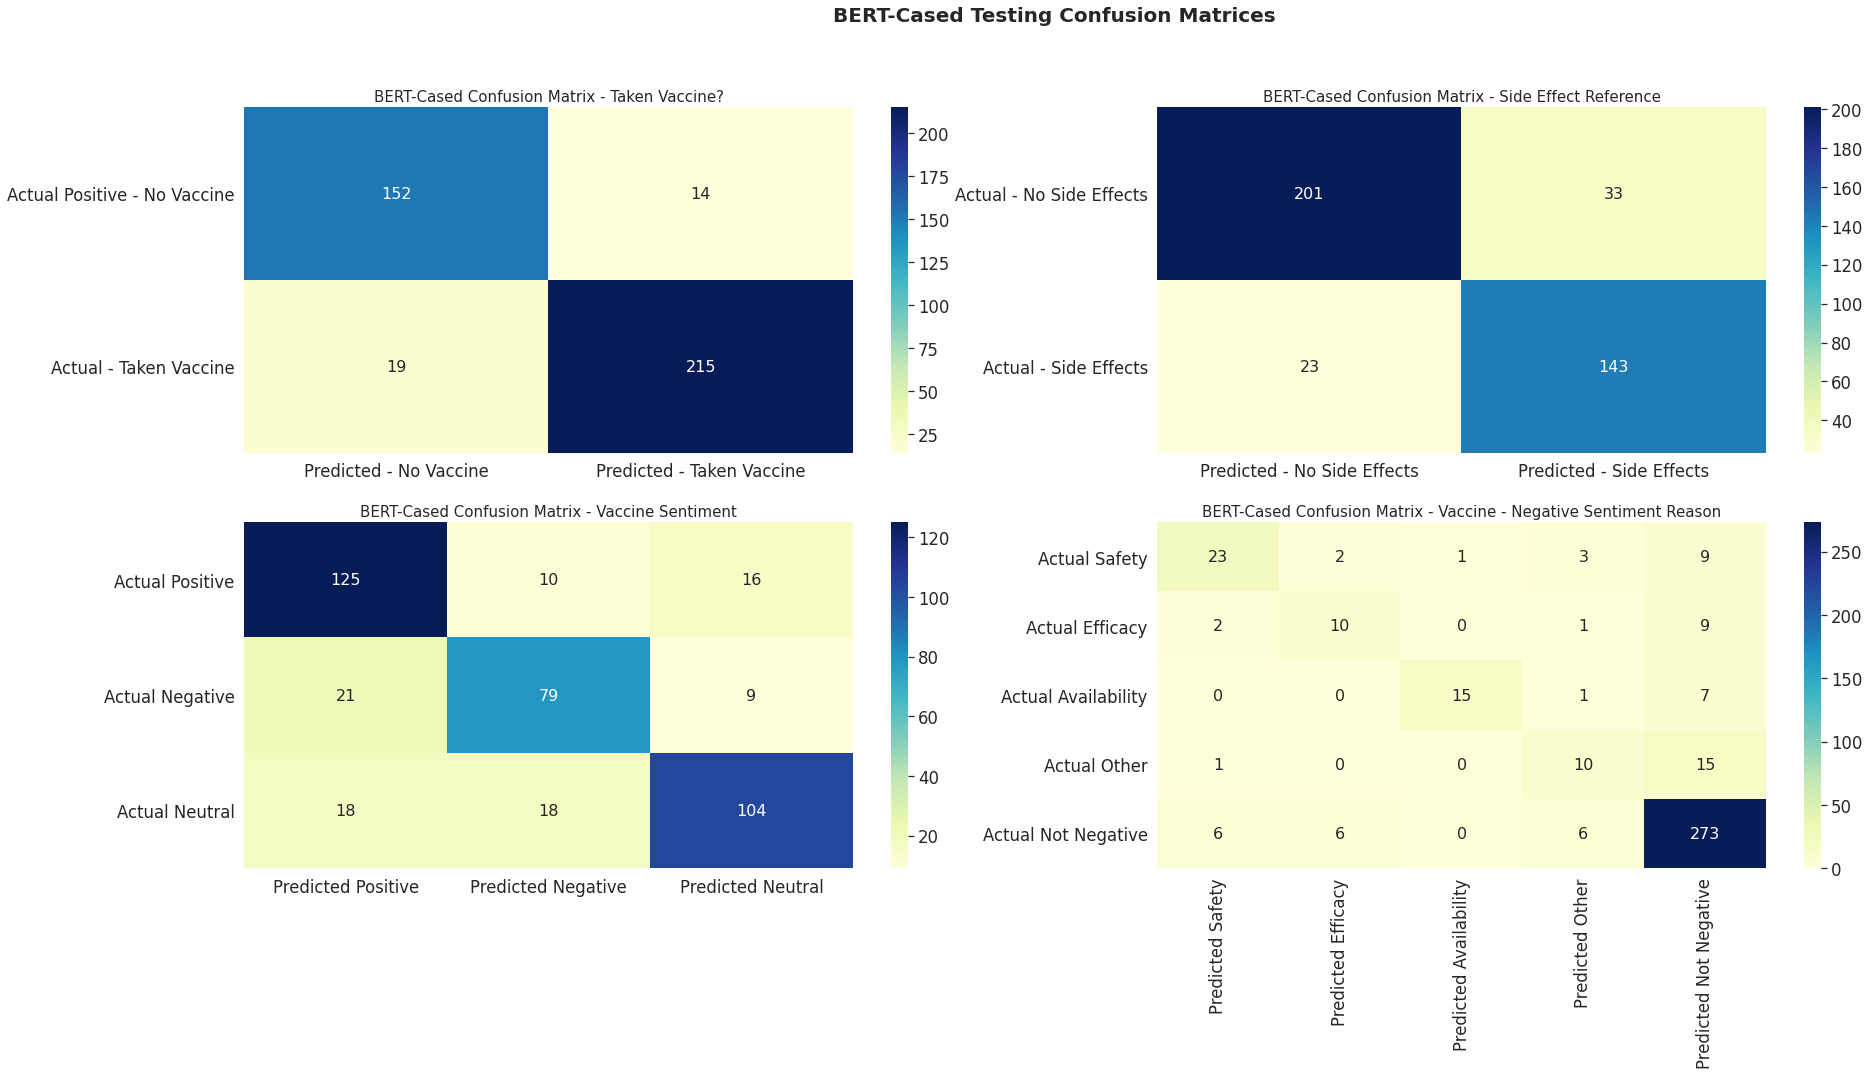

In [93]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('BERT-Cased Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('BERT-Cased Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('BERT-Cased Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('BERT-Cased Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# ELECTRA Model Evaluation

## ELECTRA Classifier - Vaccine Determintation

In [94]:
bert_model_name = 'electra_base' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [95]:
# train_size = int(0.7 * len(m1_dataset))
# val_size = int(0.10 * len(m1_dataset))
# test_size = int(0.20 * len(m1_dataset))


# full_dataset = m1_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [96]:
epochs = 10

checkpoint_filepath = './m1_electra_base/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [97]:
electra_m1 = build_classifier_model_binary()

In [98]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [99]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [100]:
electra_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [101]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 32s 188ms/step - loss: 0.5898 - binary_accuracy: 0.6327 - f1_m: 0.5750 - precision_m: 0.7364 - recall_m: 0.5071 - val_loss: 0.3008 - val_binary_accuracy: 0.8900 - val_f1_m: 0.9104 - val_precision_m: 0.9450 - val_recall_m: 0.8944
Epoch 2/10
88/88 [==============================] - 16s 178ms/step - loss: 0.2466 - binary_accuracy: 0.9142 - f1_m: 0.9144 - precision_m: 0.9460 - recall_m: 0.8976 - val_loss: 0.3396 - val_binary_accuracy: 0.9150 - val_f1_m: 0.9327 - val_precision_m: 0.9395 - val_recall_m: 0.9364
Epoch 3/10
88/88 [==============================] - 16s 178ms/step - loss: 0.1547 - binary_accuracy: 0.9523 - f1_m: 0.9524 - precision_m: 0.9737 - recall_m: 0.9375 - val_loss: 0.4364 - val_binary_accuracy: 0.8950 - val_f1_m: 0.9189 - val_precision_m: 0.9448 - val_recall_m: 0.9051
Epoch 4/10
88/88 [==============================] - 16s 178ms/step - loss: 0.0936 - binary_accura

In [102]:
electra_m1.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


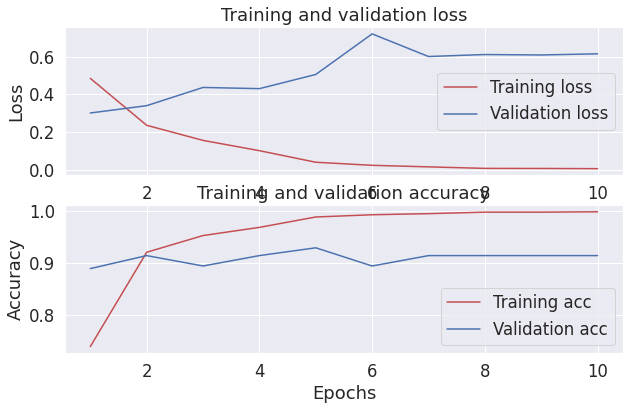

In [103]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [104]:
loss, accuracy, f1, precision, recall = electra_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 93.500000
Test Loss:  0.3466954529285431
Test Precision:  0.9391722083091736
Test Recall:  0.9541279673576355
Test f1_score:  0.9429113864898682


In [105]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifier_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(electra_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [106]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]


count = 0 

while count < len(text_list):
  print(text_list[count], predicted_categories[count], true_label_list[count])
  count += 1


b'Today dose one of covid 19 vaccine accomplished for both myself and my husband  party_popper  party_popper  party_popper  I nearly cried, because after dose two is accomplished for everyone here I\xe2\x80\x99ll actually have the chance to see my kid that I\xe2\x80\x99ve only seen 2 times in the last 14 months again.  pleading_face ' 1 1
b'I AM THANKFUL TO JOE BIDEN FOR GETTING ME A COVID VACCINE!' 1 1
b'I am not gettin no covid vaccine' 0 0
b'Ya girl got her negative Covid result back this morning (which I knew it would be) and is set-up to get her first (maybe only??) vaccine shot at 4:20. \n\nB L A Z E I T.' 1 1
b'if i\xe2\x80\x99m asleep approx 5 hours after my second covid vaccine will i not feel the effects' 1 1
b'If I have to explain ONE MORE TIME to people on how vaccine is not a complete cure that makes you invincible to covid-19 I. Will. Riot!' 0 0
b"Finally had my first covid vaccine. All this time waiting turns out they had a wrong number for me on their system and I've be

Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Taken Vaccine?')

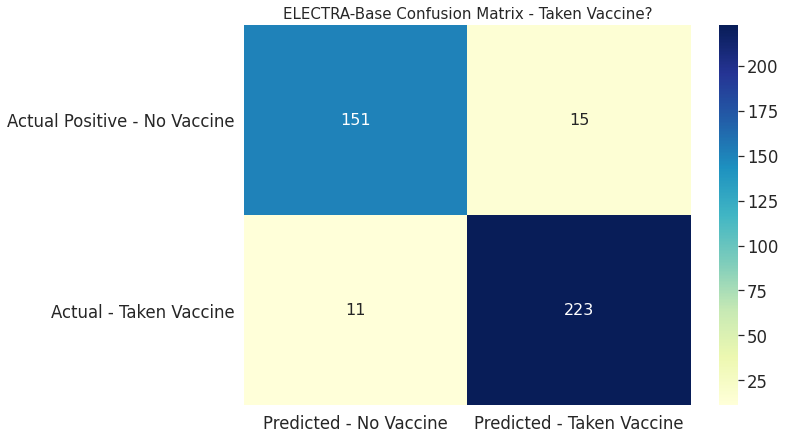

In [107]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [108]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.935
Recall Score:  0.935
f1 Score:  0.935
Accuracy Score 0.935
Macro Precision Score:  0.9345367776740325
Macro Recall Score:  0.9313150036041602
Macro f1 Score:  0.9328234807771807


## ELECTRA Classifier - Side-Effect Determination

In [109]:
# train_size = int(0.7 * len(m2_dataset))
# val_size = int(0.10 * len(m2_dataset))
# test_size = int(0.20 * len(m2_dataset))


# full_dataset = m2_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [110]:
epochs = 10

checkpoint_filepath = './m2_electra_base/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [111]:
electra_m2 = build_classifier_model_binary()


In [112]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [113]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [114]:
electra_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [115]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 33s 189ms/step - loss: 0.6720 - binary_accuracy: 0.6292 - f1_m: 0.0659 - precision_m: 0.1408 - recall_m: 0.0475 - val_loss: 0.3750 - val_binary_accuracy: 0.8200 - val_f1_m: 0.6495 - val_precision_m: 0.9615 - val_recall_m: 0.5088
Epoch 2/10
88/88 [==============================] - 16s 179ms/step - loss: 0.3946 - binary_accuracy: 0.8170 - f1_m: 0.6642 - precision_m: 0.8087 - recall_m: 0.6067 - val_loss: 0.2276 - val_binary_accuracy: 0.9250 - val_f1_m: 0.8893 - val_precision_m: 0.9582 - val_recall_m: 0.8379
Epoch 3/10
88/88 [==============================] - 16s 179ms/step - loss: 0.1684 - binary_accuracy: 0.9462 - f1_m: 0.9144 - precision_m: 0.9572 - recall_m: 0.8978 - val_loss: 0.5156 - val_binary_accuracy: 0.8900 - val_f1_m: 0.8018 - val_precision_m: 0.9846 - val_recall_m: 0.6933
Epoch 4/10
88/88 [==============================] - 16s 179ms/step - loss: 0.1159 - binary_accura

In [116]:
electra_m2.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


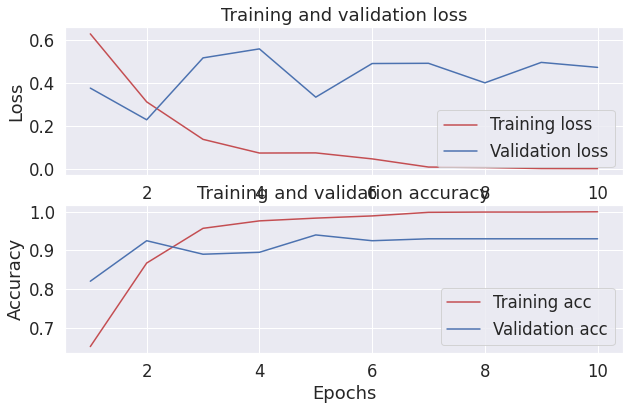

In [117]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [118]:
loss, accuracy, f1, precision, recall = electra_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 88.499999
Test Loss:  0.7194453477859497
Test Precision:  0.8511226177215576
Test Recall:  0.86466383934021
Test f1_score:  0.850872278213501


In [119]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(electra_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [120]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

'''
count = 0 

while count < len(text_list):
  print(text_list[count], predicted_categories[count], true_label_list[count])
  count += 1
'''

'\ncount = 0 \n\nwhile count < len(text_list):\n  print(text_list[count], predicted_categories[count], true_label_list[count])\n  count += 1\n'

Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Side Effect Reference')

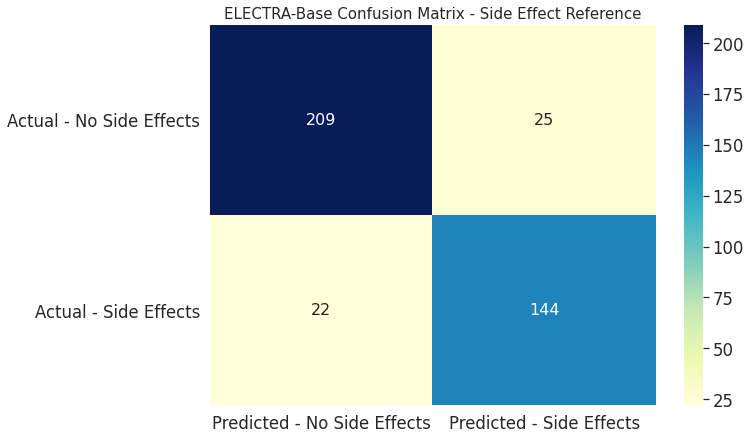

In [121]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Side Effect Reference',fontsize = 15)

In [122]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8825
Recall Score:  0.8825
f1 Score:  0.8825
Accuracy Score 0.8825
Macro Precision Score:  0.8784164553395323
Macro Recall Score:  0.8803161363402328
Macro f1 Score:  0.8793131118600546


## ELECTRA Classifier - Sentiment Analysis

In [123]:
# train_size = int(0.7 * len(m3_dataset))
# val_size = int(0.10 * len(m3_dataset))
# test_size = int(0.20 * len(m3_dataset))


# full_dataset = m3_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [124]:
epochs = 10

checkpoint_filepath = './m3_electra_base/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [125]:
electra_m3 = build_classifier_model_softmax_3_class()


In [126]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [127]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [128]:
electra_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [129]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 33s 190ms/step - loss: 1.0961 - categorical_accuracy: 0.3823 - f1_m: 0.1900 - precision_m: 0.4328 - recall_m: 0.1312 - val_loss: 0.6810 - val_categorical_accuracy: 0.7000 - val_f1_m: 0.7015 - val_precision_m: 0.7463 - val_recall_m: 0.6635
Epoch 2/10
88/88 [==============================] - 16s 179ms/step - loss: 0.7352 - categorical_accuracy: 0.7027 - f1_m: 0.6823 - precision_m: 0.7424 - recall_m: 0.6344 - val_loss: 0.5897 - val_categorical_accuracy: 0.7900 - val_f1_m: 0.7807 - val_precision_m: 0.8041 - val_recall_m: 0.7596
Epoch 3/10
88/88 [==============================] - 16s 179ms/step - loss: 0.4990 - categorical_accuracy: 0.8060 - f1_m: 0.7950 - precision_m: 0.8144 - recall_m: 0.7779 - val_loss: 0.5870 - val_categorical_accuracy: 0.7800 - val_f1_m: 0.7857 - val_precision_m: 0.7878 - val_recall_m: 0.7837
Epoch 4/10
88/88 [==============================] - 16s 179ms/step 

In [130]:
electra_m3.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


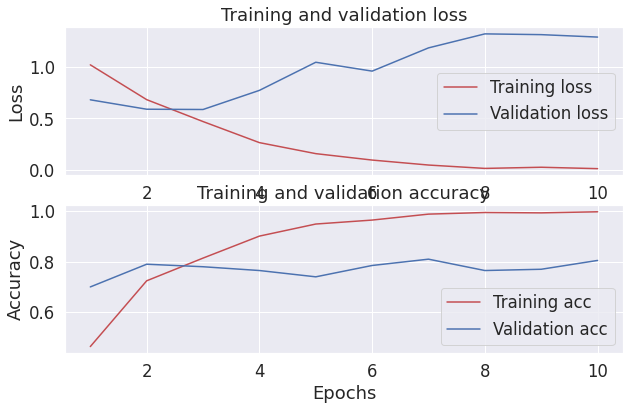

In [131]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [132]:
loss, accuracy, f1, precision, recall = electra_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 79.500002
Test Loss:  1.1200883388519287
Test Precision:  0.7950000166893005
Test Recall:  0.7950000166893005
Test f1_score:  0.794999897480011


In [133]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.argmax(bert_cased_m3.predict(tf.constant([item])),1))
    y_pred = tf.argmax(electra_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine Sentiment')

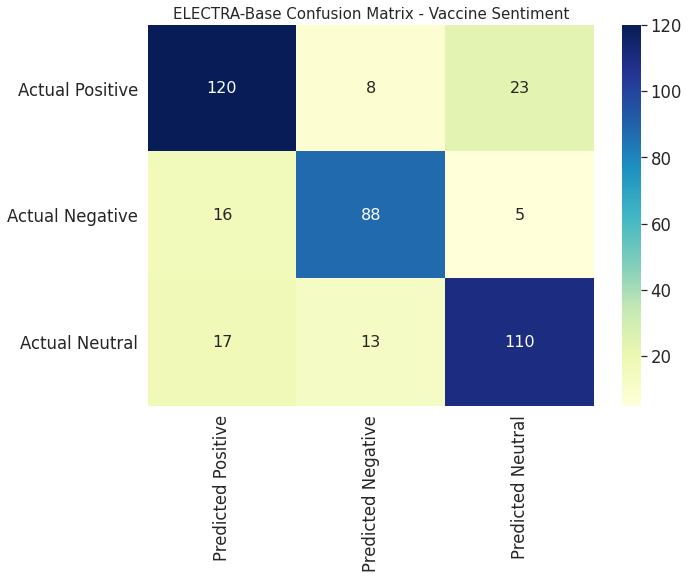

In [134]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [135]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.795
Recall Score:  0.795
f1 Score:  0.795
Accuracy Score 0.795
Macro Precision Score:  0.7962515414356143
Macro Recall Score:  0.7959185740035123
Macro f1 Score:  0.7960600134088769


## ELECTRA Classifier - Negative Sentiment Reason

In [136]:
# train_size = int(0.7 * len(m4_dataset))
# val_size = int(0.10 * len(m4_dataset))
# test_size = int(0.20 * len(m4_dataset))


# full_dataset = m4_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [137]:
epochs = 10

checkpoint_filepath = './m4_electra_base/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [138]:
electra_m4 = build_classifier_model_softmax_5_class()

In [139]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [140]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [141]:
electra_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [142]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 33s 189ms/step - loss: 1.1559 - categorical_accuracy: 0.6371 - f1_m: 0.4100 - precision_m: 0.6042 - recall_m: 0.3745 - val_loss: 0.6755 - val_categorical_accuracy: 0.7400 - val_f1_m: 0.7667 - val_precision_m: 0.8556 - val_recall_m: 0.7019
Epoch 2/10
88/88 [==============================] - 16s 179ms/step - loss: 0.7773 - categorical_accuracy: 0.6950 - f1_m: 0.7027 - precision_m: 0.8545 - recall_m: 0.6045 - val_loss: 0.6219 - val_categorical_accuracy: 0.7750 - val_f1_m: 0.7858 - val_precision_m: 0.8229 - val_recall_m: 0.7548
Epoch 3/10
88/88 [==============================] - 16s 179ms/step - loss: 0.4599 - categorical_accuracy: 0.8210 - f1_m: 0.8198 - precision_m: 0.8981 - recall_m: 0.7575 - val_loss: 0.4945 - val_categorical_accuracy: 0.8350 - val_f1_m: 0.8367 - val_precision_m: 0.8800 - val_recall_m: 0.8029
Epoch 4/10
88/88 [==============================] - 16s 179ms/step 

In [143]:
electra_m4.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


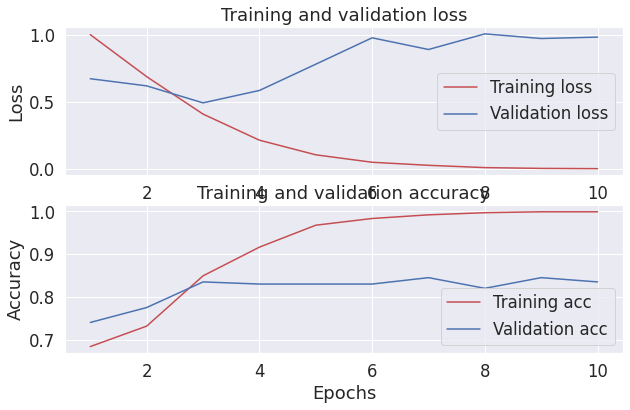

In [144]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [145]:
loss, accuracy, f1, precision, recall = electra_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 86.250001
Test Loss:  0.8530799150466919
Test Precision:  0.8621666431427002
Test Recall:  0.8600000143051147
Test f1_score:  0.8610483407974243


In [146]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    y_pred = tf.argmax(electra_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason')

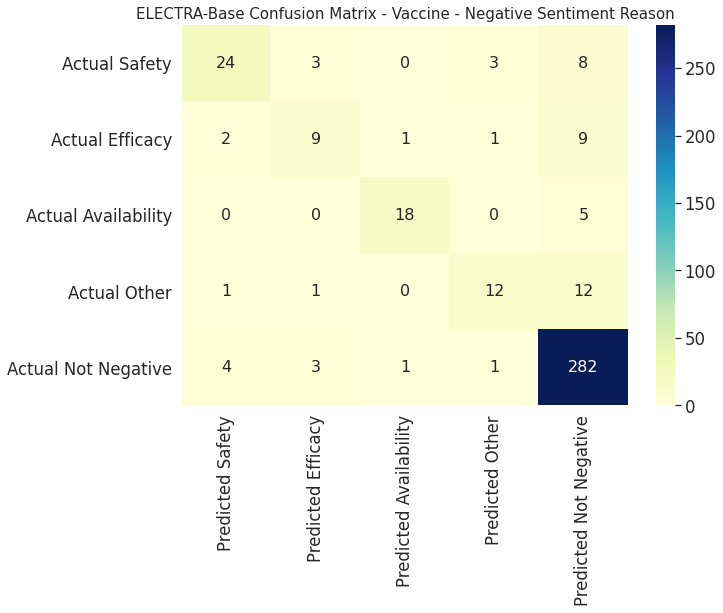

In [147]:
cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [148]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8625
Recall Score:  0.8625
f1 Score:  0.8625
Accuracy Score 0.8625
Macro Precision Score:  0.7669961929238825
Macro Recall Score:  0.650777835719684
Macro f1 Score:  0.6987690047910173


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason')

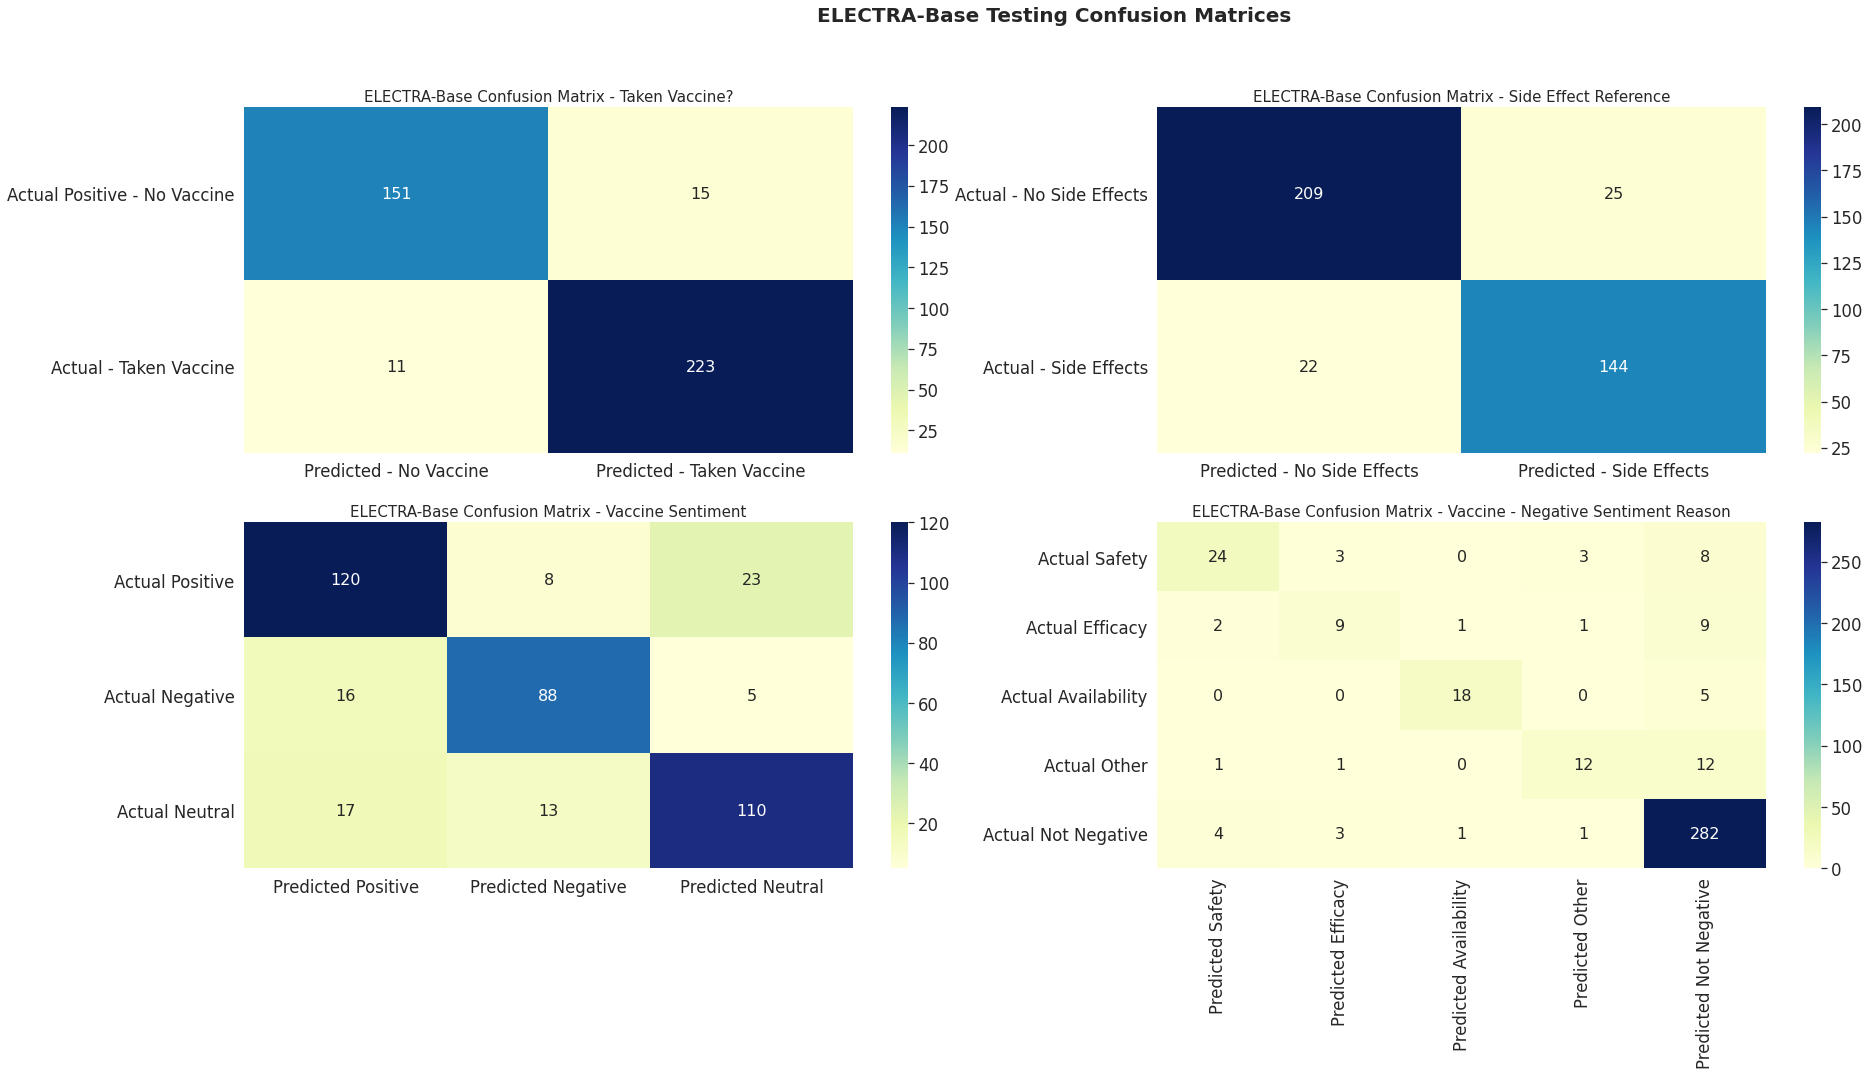

In [149]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('ELECTRA-Base Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('ELECTRA-Base Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('ELECTRA-Base Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('ELECTRA-Base Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# BERT EN UNCASED Model Evaluation

## BERT EN UNCASED Classifier - Vaccine Classification

In [30]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [31]:
# train_size = int(0.7 * len(m1_dataset))
# val_size = int(0.10 * len(m1_dataset))
# test_size = int(0.20 * len(m1_dataset))


# full_dataset = m1_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [32]:

epochs = 10

checkpoint_filepath = './m1_bert_uncased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


In [33]:
bert_uncased_m1 = build_classifier_model_binary()

In [34]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [35]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [36]:
bert_uncased_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [37]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 34s 191ms/step - loss: 0.6103 - binary_accuracy: 0.6029 - f1_m: 0.5313 - precision_m: 0.7116 - recall_m: 0.4583 - val_loss: 0.3213 - val_binary_accuracy: 0.8900 - val_f1_m: 0.9060 - val_precision_m: 0.9491 - val_recall_m: 0.8780
Epoch 2/10
88/88 [==============================] - 16s 178ms/step - loss: 0.2616 - binary_accuracy: 0.9021 - f1_m: 0.9028 - precision_m: 0.9422 - recall_m: 0.8840 - val_loss: 0.3430 - val_binary_accuracy: 0.9000 - val_f1_m: 0.9177 - val_precision_m: 0.9304 - val_recall_m: 0.9166
Epoch 3/10
88/88 [==============================] - 16s 178ms/step - loss: 0.1387 - binary_accuracy: 0.9568 - f1_m: 0.9586 - precision_m: 0.9757 - recall_m: 0.9466 - val_loss: 0.3621 - val_binary_accuracy: 0.9150 - val_f1_m: 0.9320 - val_precision_m: 0.9363 - val_recall_m: 0.9353
Epoch 4/10
88/88 [==============================] - 16s 179ms/step - loss:

In [38]:
bert_uncased_m1.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


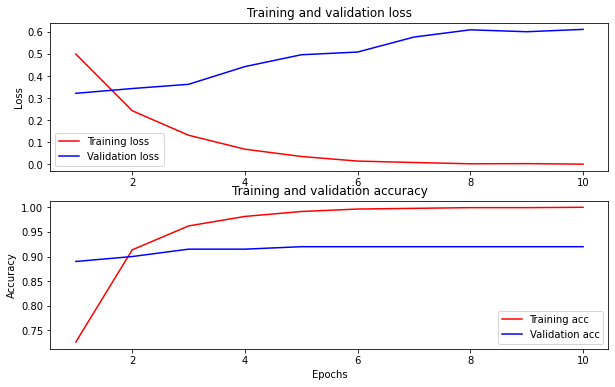

In [39]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [40]:
loss, accuracy, f1, precision, recall = bert_uncased_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 92.000002
Test Loss:  0.4565736651420593
Test Precision:  0.9352530837059021
Test Recall:  0.9318884015083313
Test f1_score:  0.9303172826766968


In [41]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifier_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_uncased_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [42]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]


# count = 0 

# while count < len(text_list):
#   print(text_list[count], predicted_categories[count], true_label_list[count])
#   count += 1


Text(0.5, 1.0, 'Bert-Uncased Confusion Matrix - Taken Vaccine?')

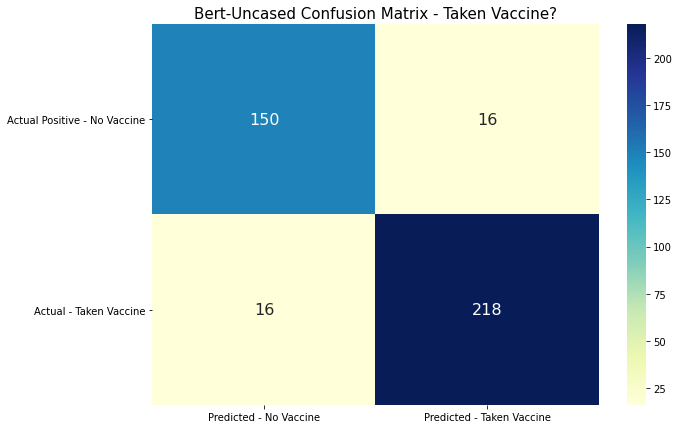

In [43]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [44]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.92
Recall Score:  0.92
f1 Score:  0.92
Accuracy Score 0.92
Macro Precision Score:  0.9176191947276284
Macro Recall Score:  0.9176191947276284
Macro f1 Score:  0.9176191947276284


##BERT EN UNCASED Classifier - Side-Effect Determination

In [45]:
# train_size = int(0.7 * len(m2_dataset))
# val_size = int(0.10 * len(m2_dataset))
# test_size = int(0.20 * len(m2_dataset))


# full_dataset = m2_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [46]:
epochs = 10

checkpoint_filepath = './m2_bert_uncased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [47]:
bert_uncased_m2 = build_classifier_model_binary()


In [48]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [49]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [50]:
bert_uncased_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [51]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 34s 188ms/step - loss: 0.6777 - binary_accuracy: 0.6255 - f1_m: 0.0607 - precision_m: 0.1618 - recall_m: 0.0423 - val_loss: 0.3324 - val_binary_accuracy: 0.8600 - val_f1_m: 0.7916 - val_precision_m: 0.8870 - val_recall_m: 0.7292
Epoch 2/10
88/88 [==============================] - 16s 178ms/step - loss: 0.3640 - binary_accuracy: 0.8512 - f1_m: 0.7435 - precision_m: 0.8827 - recall_m: 0.6659 - val_loss: 0.2639 - val_binary_accuracy: 0.9150 - val_f1_m: 0.8716 - val_precision_m: 0.9744 - val_recall_m: 0.7948
Epoch 3/10
88/88 [==============================] - 16s 179ms/step - loss: 0.2104 - binary_accuracy: 0.9357 - f1_m: 0.8916 - precision_m: 0.9615 - recall_m: 0.8582 - val_loss: 0.3845 - val_binary_accuracy: 0.9150 - val_f1_m: 0.8698 - val_precision_m: 0.8985 - val_recall_m: 0.8511
Epoch 4/10
88/88 [==============================] - 16s 179ms/step - loss:

In [52]:
bert_uncased_m2.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


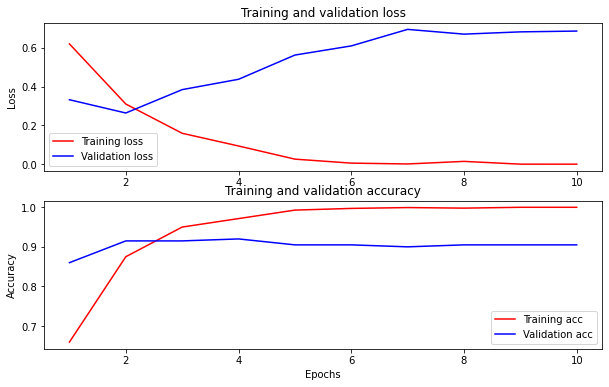

In [53]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [54]:
loss, accuracy, f1, precision, recall = bert_uncased_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 88.749999
Test Loss:  0.8109937310218811
Test Precision:  0.8871067762374878
Test Recall:  0.8265699148178101
Test f1_score:  0.8419744372367859


In [55]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_uncased_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [56]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

'''
count = 0 

while count < len(text_list):
  print(text_list[count], predicted_categories[count], true_label_list[count])
  count += 1
'''

'\ncount = 0 \n\nwhile count < len(text_list):\n  print(text_list[count], predicted_categories[count], true_label_list[count])\n  count += 1\n'

Text(0.5, 1.0, 'Bert-Uncased Confusion Matrix - Side Effect Reference')

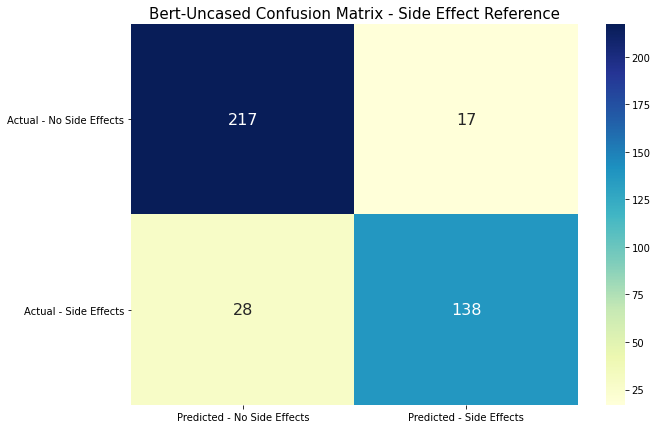

In [57]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Side Effect Reference',fontsize = 15)

In [58]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8875
Recall Score:  0.8875
f1 Score:  0.8875
Accuracy Score 0.8875
Macro Precision Score:  0.8880184331797235
Macro Recall Score:  0.8793378642776233
Macro f1 Score:  0.8829336819308138


##BERT EN UNCASED Classifier - Sentiment Analysis

In [59]:
# train_size = int(0.7 * len(m3_dataset))
# val_size = int(0.10 * len(m3_dataset))
# test_size = int(0.20 * len(m3_dataset))


# full_dataset = m3_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [60]:
epochs = 10

checkpoint_filepath = './m3_bert_uncased_/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [61]:
bert_uncased_m3 = build_classifier_model_softmax_3_class()


In [62]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [63]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [64]:
bert_uncased_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [65]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 34s 189ms/step - loss: 1.1403 - categorical_accuracy: 0.4006 - f1_m: 0.2745 - precision_m: 0.4385 - recall_m: 0.2094 - val_loss: 0.7024 - val_categorical_accuracy: 0.6800 - val_f1_m: 0.6710 - val_precision_m: 0.6964 - val_recall_m: 0.6490
Epoch 2/10
88/88 [==============================] - 16s 178ms/step - loss: 0.7504 - categorical_accuracy: 0.6835 - f1_m: 0.6706 - precision_m: 0.7140 - recall_m: 0.6348 - val_loss: 0.6139 - val_categorical_accuracy: 0.7300 - val_f1_m: 0.7323 - val_precision_m: 0.7449 - val_recall_m: 0.7212
Epoch 3/10
88/88 [==============================] - 16s 179ms/step - loss: 0.5526 - categorical_accuracy: 0.7755 - f1_m: 0.7695 - precision_m: 0.7975 - recall_m: 0.7447 - val_loss: 0.5869 - val_categorical_accuracy: 0.7700 - val_f1_m: 0.7749 - val_precision_m: 0.7811 - val_recall_m: 0.7692
Epoch 4/10
88/88 [==========================

In [66]:
bert_uncased_m3.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


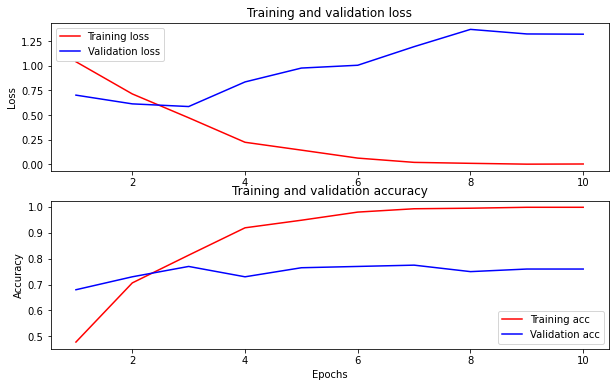

In [67]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [68]:
loss, accuracy, f1, precision, recall = bert_uncased_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 76.499999
Test Loss:  1.2764564752578735
Test Precision:  0.7649999856948853
Test Recall:  0.7649999856948853
Test f1_score:  0.7649999260902405


In [69]:
model_final_test_results.append((bert_model_name, 'bert_uncased_m3', loss, accuracy,precision,recall,f1))

In [70]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:


    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.argmax(bert_uncased_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

    

  for item in batch[1]:
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'Bert-Uncased Confusion Matrix - Vaccine Sentiment')

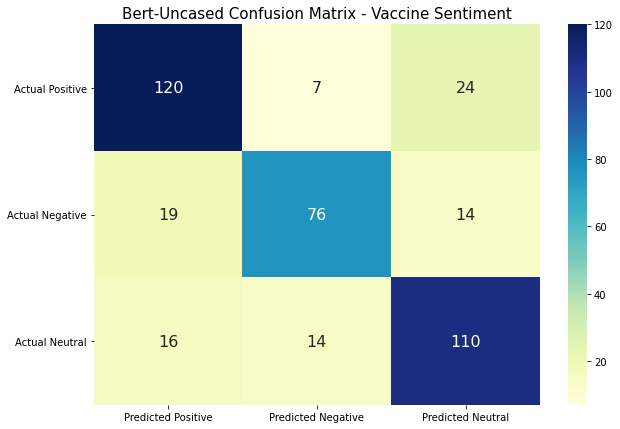

In [71]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [72]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.765
Recall Score:  0.765
f1 Score:  0.765
Accuracy Score 0.765
Macro Precision Score:  0.7669806487565051
Macro Recall Score:  0.7592213262970903
Macro f1 Score:  0.7620222306829959


##BERT EN UNCASED Classifier - Negative Sentiment Reason

In [73]:
# train_size = int(0.7 * len(m4_dataset))
# val_size = int(0.10 * len(m4_dataset))
# test_size = int(0.20 * len(m4_dataset))


# full_dataset = m4_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [74]:
epochs = 10

checkpoint_filepath = './m4_bert_uncased_/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [75]:
bert_uncased_m4 = build_classifier_model_softmax_5_class()

In [76]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [77]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [78]:
bert_uncased_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [79]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 32s 188ms/step - loss: 1.4545 - categorical_accuracy: 0.3893 - f1_m: 0.2597 - precision_m: 0.3927 - recall_m: 0.2303 - val_loss: 0.7411 - val_categorical_accuracy: 0.7550 - val_f1_m: 0.7623 - val_precision_m: 0.8259 - val_recall_m: 0.7115
Epoch 2/10
88/88 [==============================] - 16s 179ms/step - loss: 0.7799 - categorical_accuracy: 0.7251 - f1_m: 0.6993 - precision_m: 0.8363 - recall_m: 0.6095 - val_loss: 0.5900 - val_categorical_accuracy: 0.8100 - val_f1_m: 0.8145 - val_precision_m: 0.8702 - val_recall_m: 0.7692
Epoch 3/10
88/88 [==============================] - 16s 178ms/step - loss: 0.4419 - categorical_accuracy: 0.8345 - f1_m: 0.8356 - precision_m: 0.9020 - recall_m: 0.7815 - val_loss: 0.5087 - val_categorical_accuracy: 0.8450 - val_f1_m: 0.8513 - val_precision_m: 0.8731 - val_recall_m: 0.8317
Epoch 4/10
88/88 [==========================

In [80]:
bert_uncased_m4.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


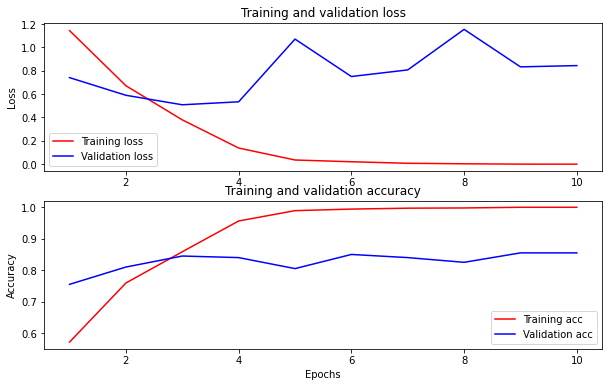

In [81]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [82]:
loss, accuracy, f1, precision, recall = bert_uncased_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 82.749999
Test Loss:  0.926636278629303
Test Precision:  0.8316429257392883
Test Recall:  0.824999988079071
Test f1_score:  0.8281343579292297


In [83]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:


    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.argmax(bert_uncased_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

    

  for item in batch[1]:
    true_label_list.append(tf.argmax(item))

Text(0.5, 1.0, 'Bert-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason')

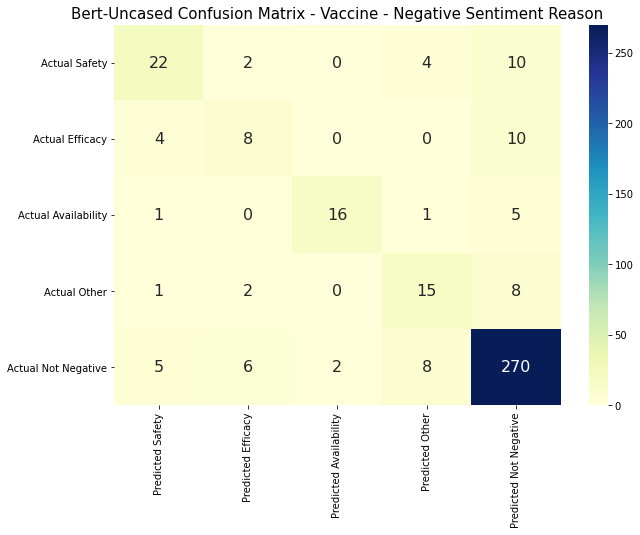

In [84]:

cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [85]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8275
Recall Score:  0.8275
f1 Score:  0.8275
Accuracy Score 0.8275
Macro Precision Score:  0.6853606789250353
Macro Recall Score:  0.6285988068879858
Macro f1 Score:  0.6529705158767337


Text(0.5, 1.0, 'BERT-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason')

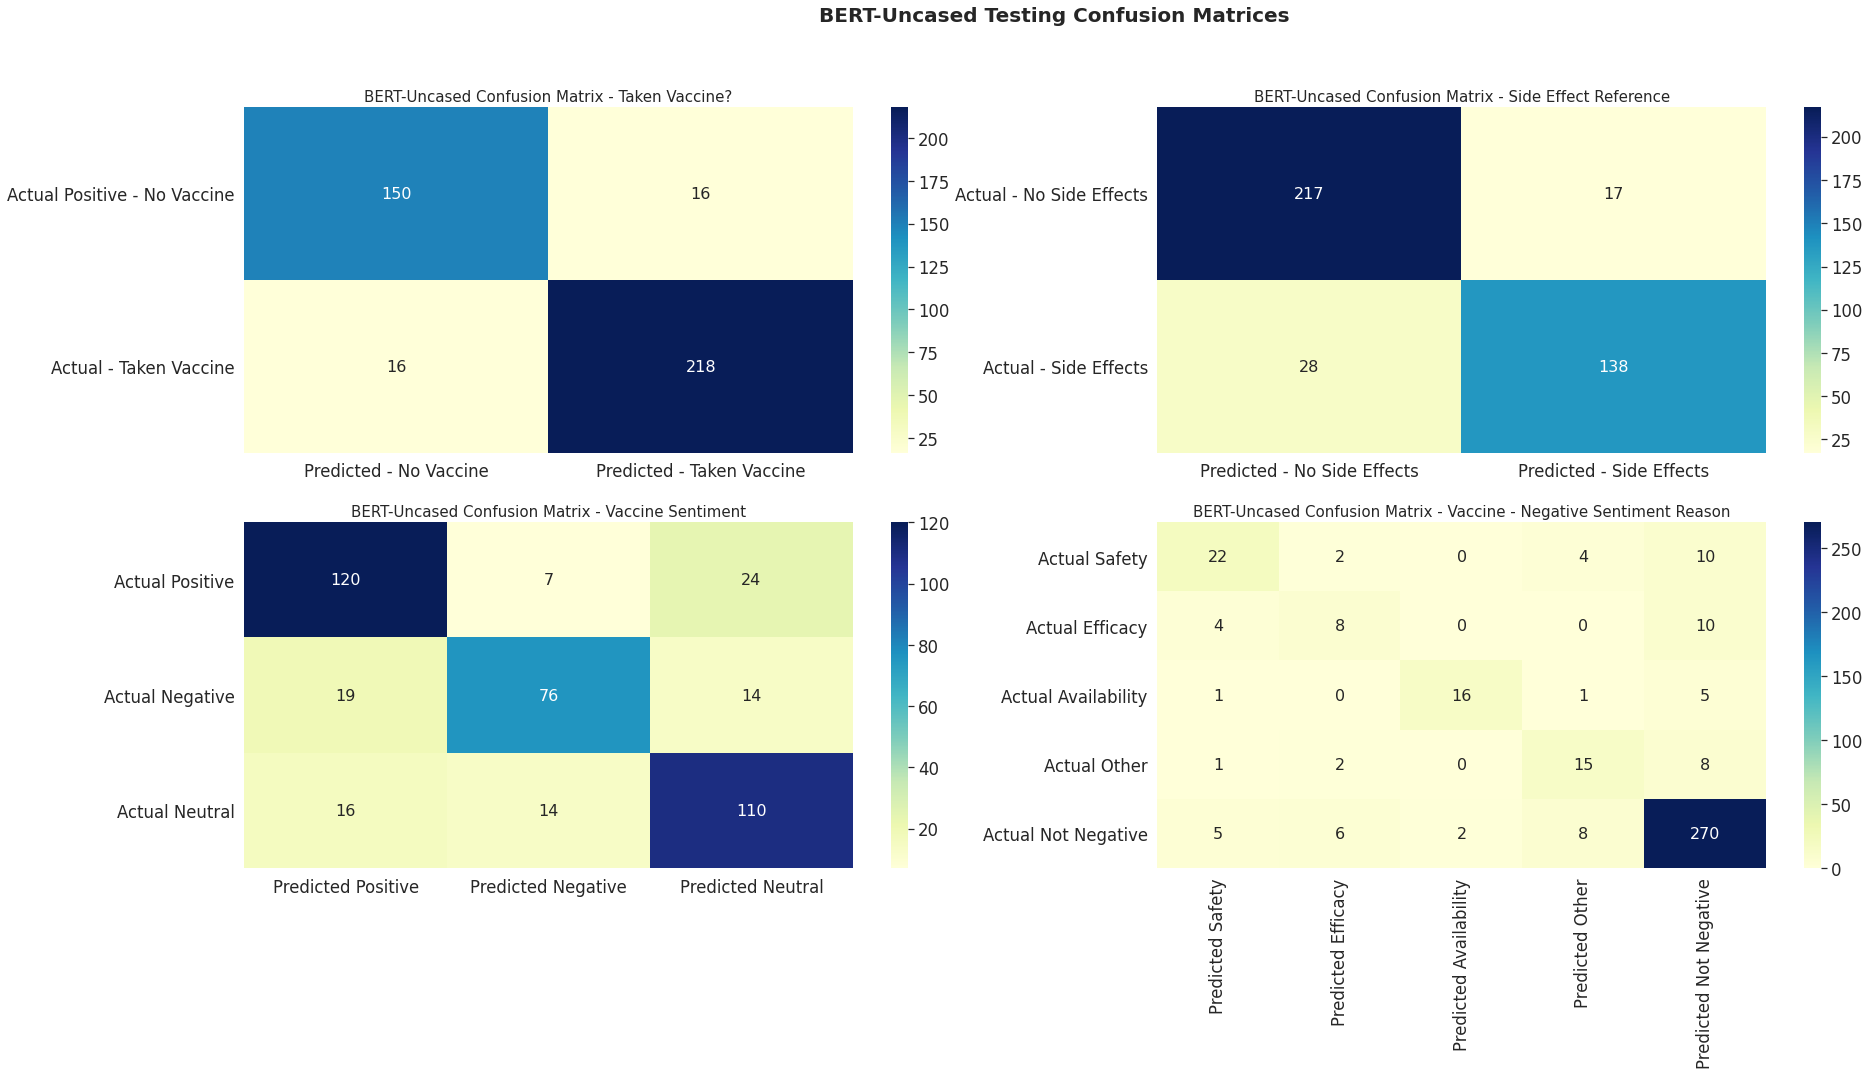

In [86]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('BERT-Uncased Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('BERT-Uncased Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('BERT-Uncased Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('BERT-Uncased Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('BERT-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# Save Results to Excel

In [87]:
model_final_test_results

[('bert_en_uncased_L-12_H-768_A-12',
  'bert_uncased_m1',
  0.4565736651420593,
  0.92,
  0.92,
  0.92,
  0.92,
  0.9176191947276284,
  0.9176191947276284,
  0.9176191947276284),
 ('bert_en_uncased_L-12_H-768_A-12',
  'bert_uncased_m2',
  0.8109937310218811,
  0.8875,
  0.8875,
  0.8875,
  0.8875,
  0.8880184331797235,
  0.8793378642776233,
  0.8829336819308138),
 ('bert_en_uncased_L-12_H-768_A-12',
  'bert_uncased_m3',
  1.2764564752578735,
  0.7649999856948853,
  0.7649999856948853,
  0.7649999856948853,
  0.7649999260902405),
 ('bert_en_uncased_L-12_H-768_A-12',
  'bert_uncased_m3',
  1.2764564752578735,
  0.765,
  0.765,
  0.765,
  0.765,
  0.7669806487565051,
  0.7592213262970903,
  0.7620222306829959),
 ('bert_en_uncased_L-12_H-768_A-12',
  'bert_uncased_m4',
  0.926636278629303,
  0.8275,
  0.8275,
  0.8275,
  0.8275,
  0.6853606789250353,
  0.6285988068879858,
  0.6529705158767337)]

In [88]:
results = pd.DataFrame(model_final_test_results)

In [89]:
from datetime import datetime

In [90]:
results['timestamp'] = datetime.now()

In [91]:
results = results.rename(columns={0: "TensorHub Model Name", 1: "Classifier Task Name", 2: "Test Loss",3:'Test Micro Precision',4:'Test Micro Recall',5:'Test Micro F1 Score',6:'Test Accuracy',7:'Test Macro Precision',8:'Test Macro Recall',9:'Test Macro F1'})

In [92]:
saved_file = input('Enter a file name: ')
results.to_excel(saved_file)

Enter a file name: COVID_19_Vaccine_Classifier_Results.xlsx
